In [11]:
from Minesweeper import *
from MS_GUI import *
from MS_AI import *
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

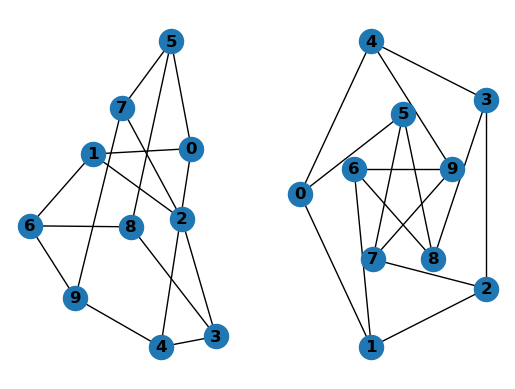

In [6]:
G = nx.petersen_graph()
subax1 = plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

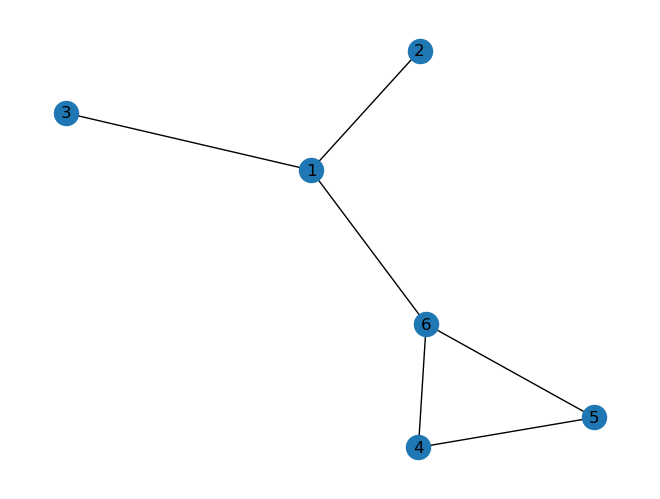

In [12]:
graph = nx.Graph()

graph.add_node(1, tile=MS_Tile(1))
graph.add_node(2, tile=MS_Tile(2))
graph.add_node(3, tile=MS_Tile(3))
graph.add_edge(1, 2)
graph.add_edge(1, 3)

graph.add_node(4, tile=MS_Tile(4))
graph.add_node(5, tile=MS_Tile(5))
graph.add_node(6, tile=MS_Tile(6))
graph.add_edge(4, 5)
graph.add_edge(4, 6)
graph.add_edge(6, 1)
graph.add_edge(5, 6)

nx.draw(graph, with_labels=True, pos=nx.spring_layout(graph))

In [17]:
graph.add_edge(4, 5, foo=[1,2])
for n in graph.edges:
    print(graph.edges[n])

{}
{}
{}
{'foo': [1, 2]}
{}
{}
